[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb)

# Downloading Data

In [2]:
%%capture
!wget -O assignment1-dataset.csv "https://raw.githubusercontent.com/atanilson/Com634-AppliedAI/refs/heads/main/assignment1/assignment1-dataset.csv"

---

# University of Liverpool

## COMP634 - Applied AI

---

In [3]:
# import libraries here

# Data managment libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler #******Delete************

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import joblib

# Evaluating
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

# 1. **Data Management**


In this part, you need to:

1.   analyse and prepare the data. Use plots, graphs, and tables (such as histogram, box plots, scatterplots etc.) to better analyse the dataset and identify issues or potential improvements in the data, including (but not limited to) unnecessary feature/variable which can be dropped/removed, standardization, encoding, etc;
2.   split the data and define your experimental protocol (such as cross-validation or k-fold).

In [4]:
# Loading Data
data = pd.read_csv("assignment1-dataset.csv")
data.head()

,Gender,Age,Height,Weight,family_overweight,HCF,VegMeals,Meals,FD,MealsBetw,SMOKE,WaterQ,CaloriesMonitor,PhysAct,TechUsage,AlcConsume,TransMeans,ObesityLvl
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,0.832932,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,1.056377,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,0.962160,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,0.908676,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,0.000000,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [5]:
# Checking the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             2111 non-null   object 
 1   Age                2111 non-null   float64
 2   Height             2111 non-null   float64
 3   Weight             2111 non-null   float64
 4   family_overweight  2111 non-null   object 
 5   HCF                2111 non-null   object 
 6   VegMeals           2111 non-null   float64
 7   Meals              2111 non-null   float64
 8   FD                 2111 non-null   float64
 9   MealsBetw          2111 non-null   object 
 10  SMOKE              2111 non-null   object 
 11  WaterQ             2111 non-null   float64
 12  CaloriesMonitor    2111 non-null   object 
 13  PhysAct            2111 non-null   float64
 14  TechUsage          2111 non-null   float64
 15  AlcConsume         2111 non-null   object 
 16  TransMeans         2111 

The dataset contains 17 column, 9 are float numerical and 9 are objects

In [6]:
len(data)

2111

Checking for duplicates.

In [7]:
# Checking if all rows on the dataset are unique
unique = data.duplicated().sum() == 0

if unique:
    print("All rows in the data are unique.")
else:
    print(f"There are {data.duplicated().sum()} duplicate rows in the data.")

There are 20 duplicate rows in the data.


In [8]:
# Deletinf Duplicate
data.drop_duplicates(inplace=True)

In [9]:
# Checking Missing value
data.isnull().sum()

,0
Gender,0
Age,0
Height,0
Weight,0
family_overweight,0
HCF,0
VegMeals,0
Meals,0
FD,0
MealsBetw,0


## Studying Target column - ``ObesityLvl``

In [10]:
data['ObesityLvl'].describe()

,ObesityLvl
count,2091
unique,7
top,Obesity_Type_I
freq,351


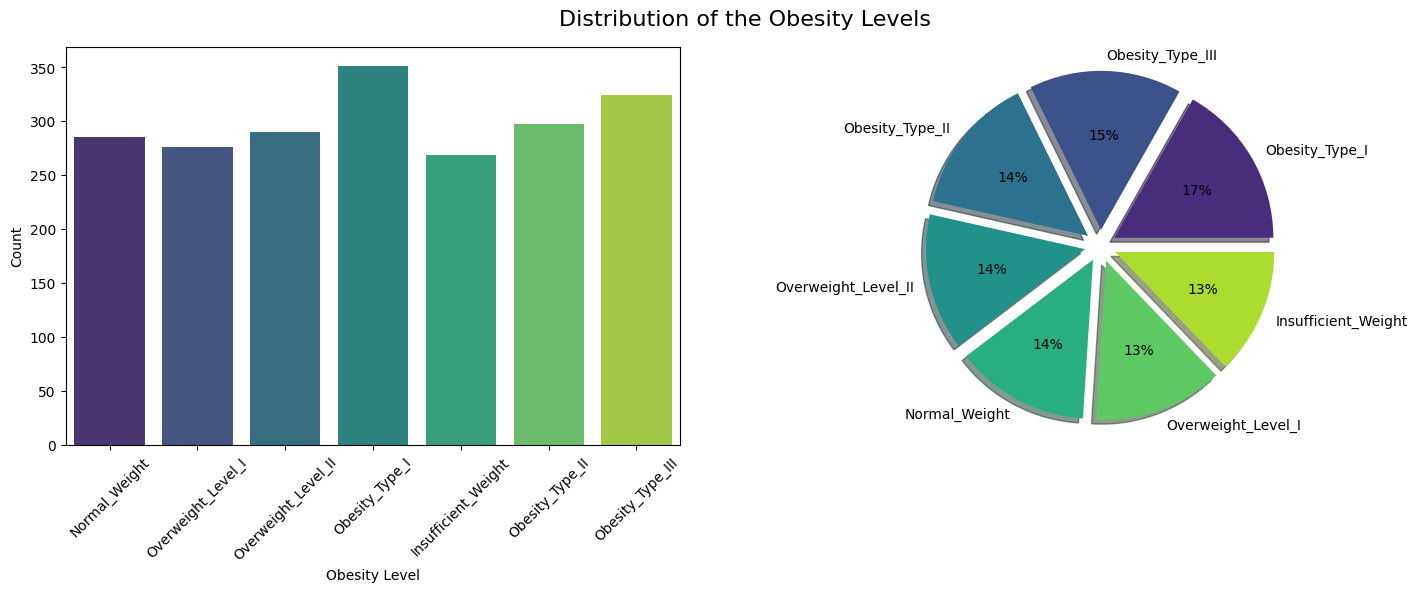

In [11]:
# Plotting the target column
fig, axes = plt.subplots(1, 2, figsize=(15, 6))


sns.countplot(ax=axes[0], x="ObesityLvl", hue="ObesityLvl", data=data, palette='viridis')
axes[0].set_xlabel('Obesity Level')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)


axes[1].pie(
    data['ObesityLvl'].value_counts(),
    shadow=True,
    explode=[.1 for _ in range(len(data['ObesityLvl'].unique()))],
    labels=data['ObesityLvl'].value_counts().index,
    autopct='%1.f%%',
    colors=sns.color_palette('viridis', len(data['ObesityLvl'].unique()))
)

fig.suptitle('Distribution of the Obesity Levels', fontsize=16)
plt.tight_layout()
plt.show()

The problem aims to infer a patient’s obesity level, the target variable is a categorical ordinal variable, therefore we will focus on modelling the problem as classification.

## Distribution of Numerical Features

Studying the distribution of all features to then focus on the relevant ones during feature engineering.

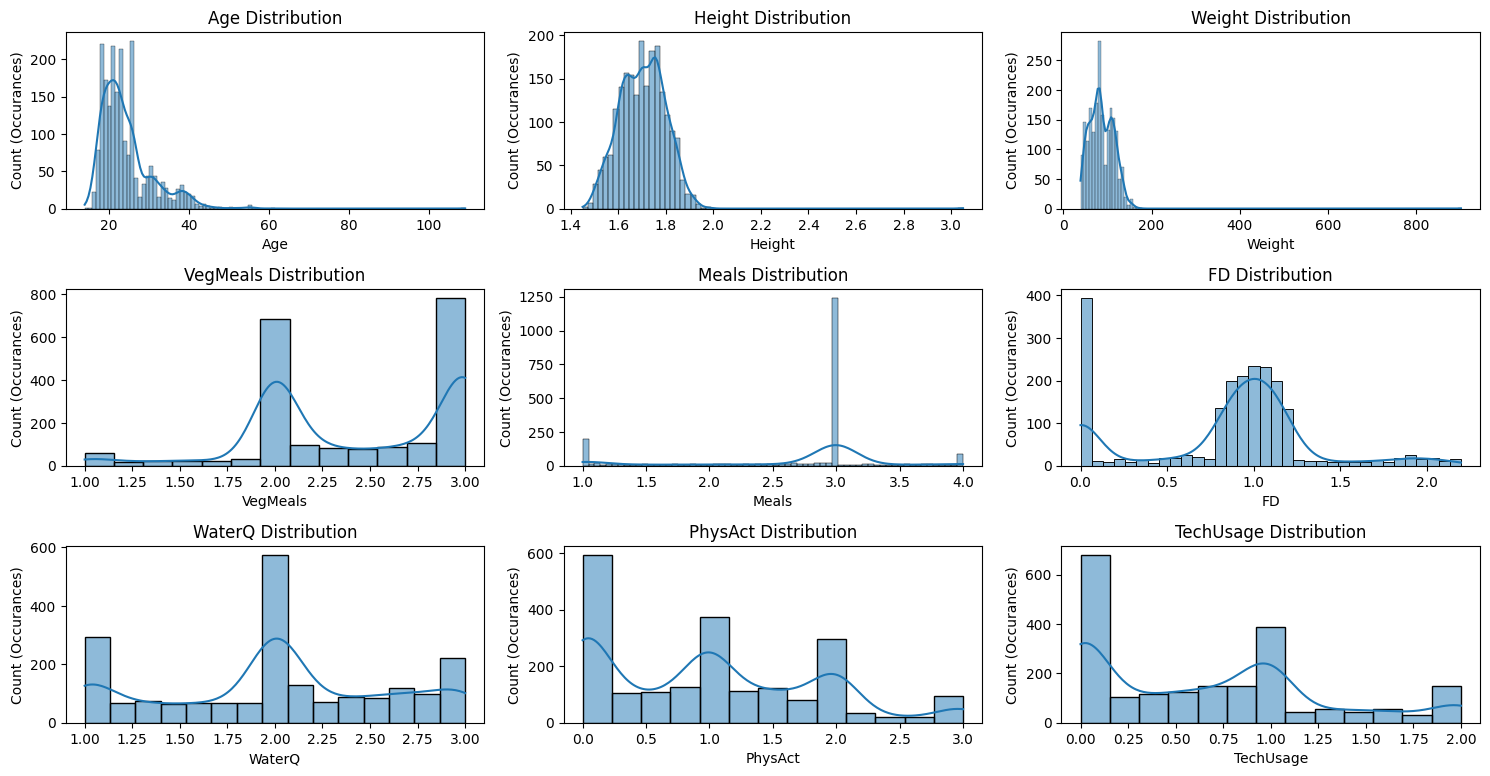

In [12]:
# Extracting the numerical features
numeric_features = data.select_dtypes(include="number").columns

# Plotting all numerical distribution
plt.figure(figsize=(15, 10))
for i, fea in enumerate(numeric_features, 1):
  plt.subplot(len(numeric_features)//3+1, 3, i)
  sns.histplot(data[fea], kde=True)
  plt.title(f"{fea} Distribution")
  plt.xlabel(fea)
  plt.ylabel('Count (Occurances)')

plt.tight_layout()
plt.show()

These distributions reveal that the dataset primarily consists of young adults, around 18-20 years old, as seen in the Age distribution, whose Height and Weight are generally normally distributed but include a few high outliers. The lifestyle features like VegMeals,Physical Activity, and TechUsage exhibit diffent distributions different peaks, indicating that the sample is not homogenous but is comprised of distinct subgroups with different habits. Most people eat 3 meals a day.

## Distribution of all Categorical

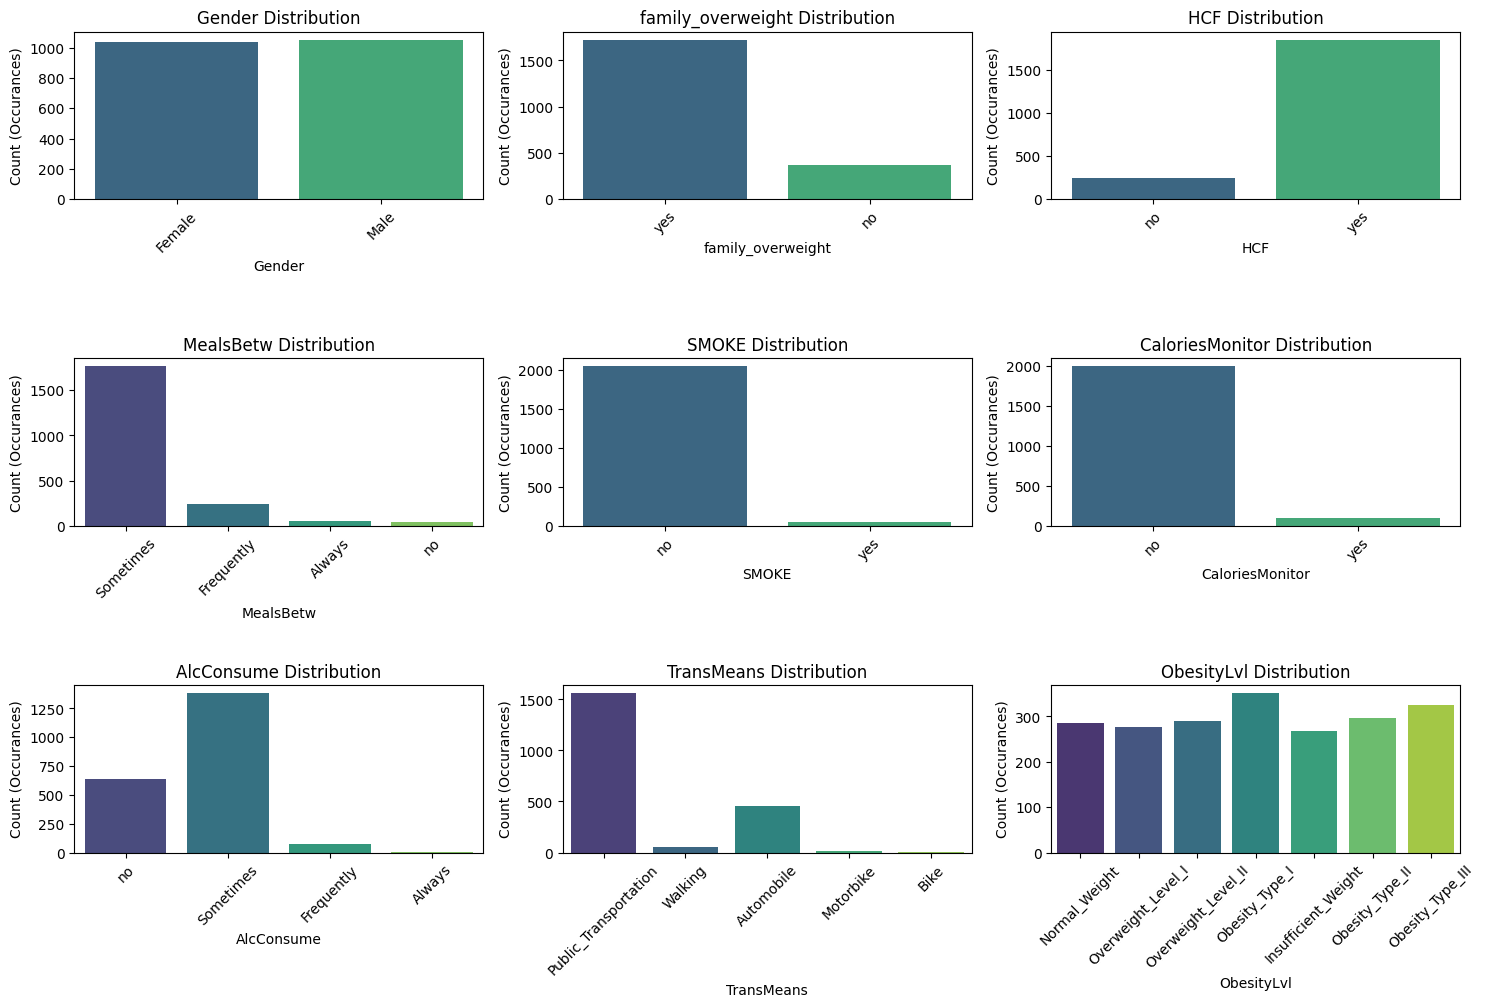

In [13]:
categoriacal_features = data.select_dtypes(include=['object', 'category']).columns

plt.figure(figsize=(15, 12))
for i, fea in enumerate(categoriacal_features, 1):
  plt.subplot(len(categoriacal_features)//3+1, 3, i)
  sns.countplot(x=fea, data=data,  hue=fea, palette='viridis')
  plt.title(f'{fea} Distribution')
  plt.xlabel(fea)
  plt.ylabel('Count (Occurances)')
  plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

 The Gender Distribution is balanced between. A majority of respondents have a family history of being overweight. Most individuals reported exhibit high-calorie food consumption. The MealsBetw shows that most people sometimes eat between meals, while few do it frequently or always. The SMOKE distribution indicates that very few smoke. Likewise, only a small portionof participants monitor their calorie intake. The AlcConsume variable reveals that most people drink alcohol “sometimes,” and some people don't drink. Regarding transportation means there is a high frequency of public transportation usage.

## Correlation

Studying the correlation between features

In [14]:
# To check the correlation will first encode the Categorical variable

# Ordinal data will be categorised numerically.
obesity_mapping = {
    'Insufficient_Weight': 1,
    'Normal_Weight': 2,
    'Overweight_Level_I': 3,
    'Overweight_Level_II': 4,
    'Obesity_Type_I': 5,
    'Obesity_Type_II': 6,
    'Obesity_Type_III': 7
}

# Applying the mapping.
data['ObesityLvl'] = data['ObesityLvl'].map(obesity_mapping)

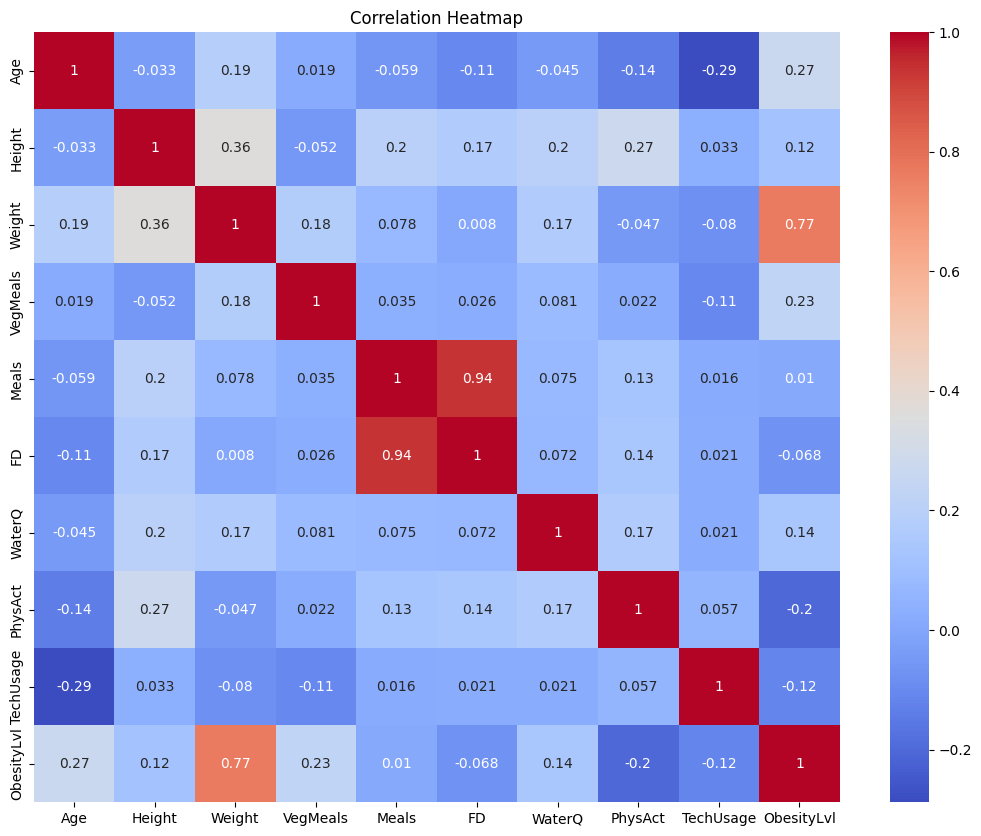

In [15]:
# Correlation of numeric variables
def plot_correlationN():
  numeric_data = data.select_dtypes(include=[np.number])

  plt.figure(figsize=(13, 10))
  sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm')

  plt.title('Correlation Heatmap')
  plt.show()

plot_correlationN()

High correlation,	Weight and ObesityLvl, Moderate Correlations,	Height and Weight, taller individuals tend to weigh more, which is biologically expected.

In [16]:
## Categorical

In [17]:
## Encoding categorical data
data_c = pd.get_dummies(data, columns=categoriacal_features, drop_first=True)
correlation = data_c.corr()
#correlation =  pd.get_dummies(data, columns=categoriacal_features, drop_first=True).corr()

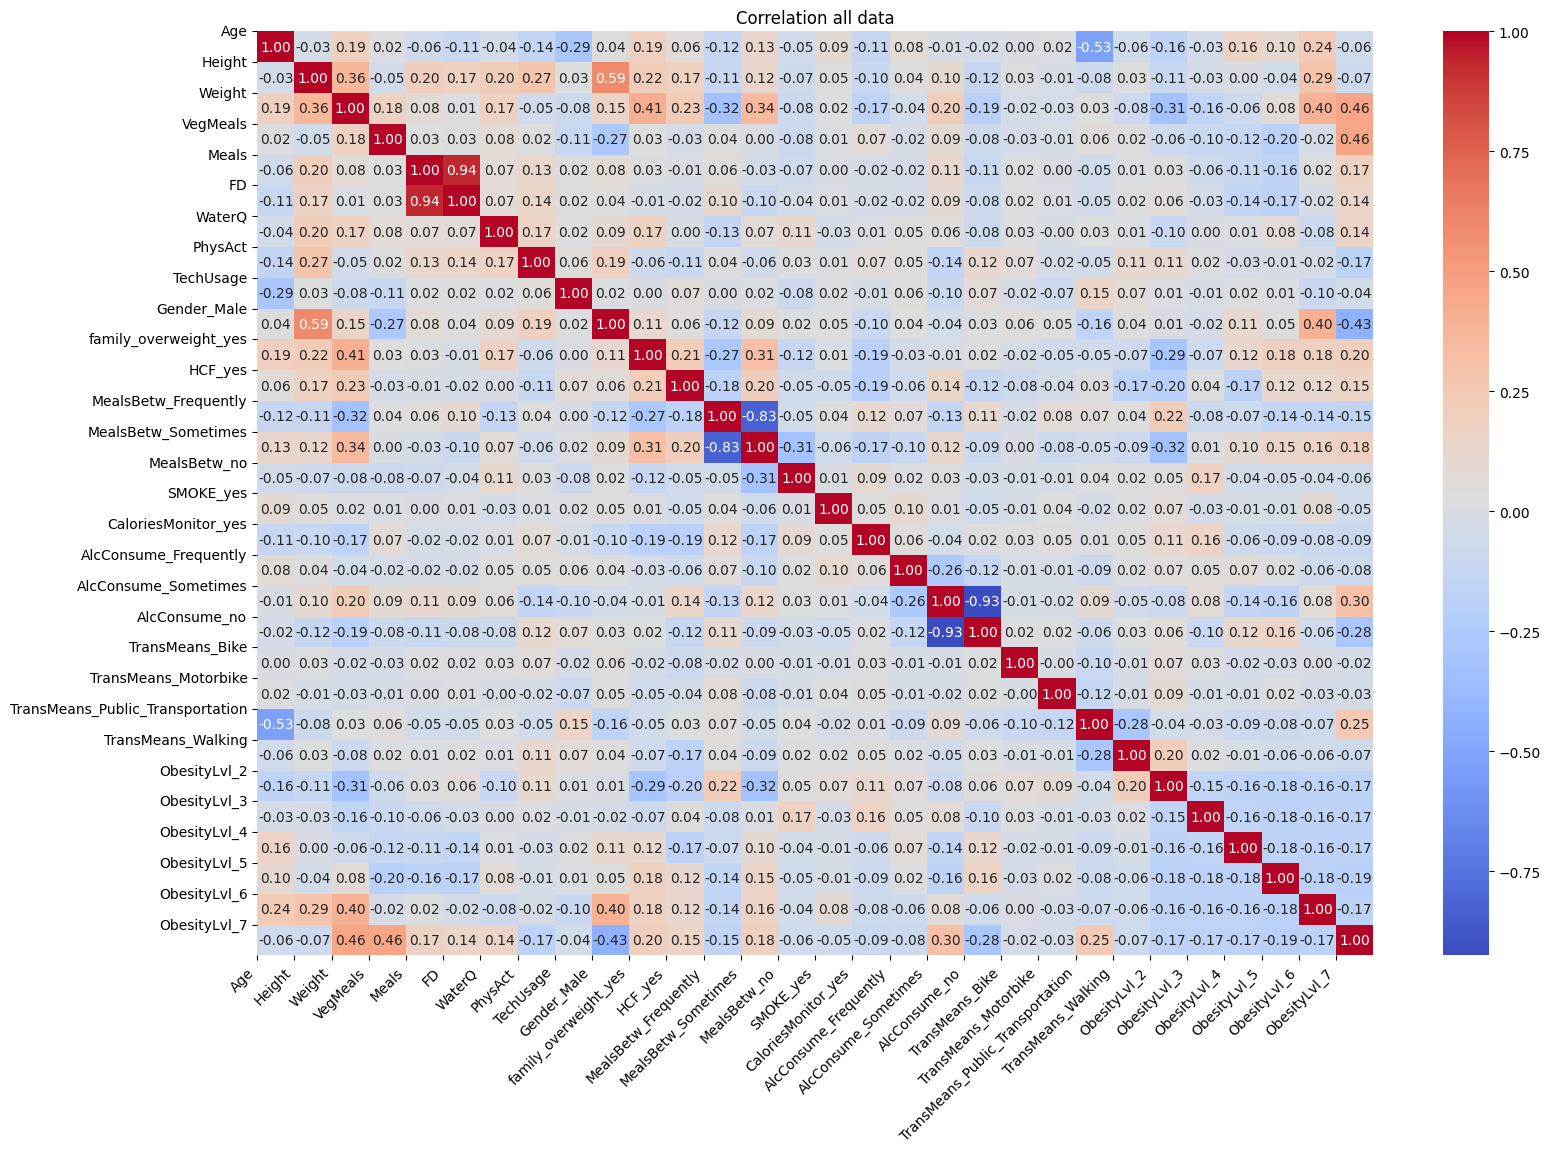

In [18]:
# Ploting
fig, ax = plt.subplots(figsize=(18, 12))
sns.heatmap(correlation, annot=True, fmt='.2f', ax=ax, cmap='coolwarm')
ax.set_title('Correlation all data')

ax.set_xticks(np.arange(len(correlation.columns)))
ax.set_yticks(np.arange(len(correlation.columns)))
ax.set_xticklabels(correlation.columns, rotation=45, ha='right')
ax.set_yticklabels(correlation.columns)
plt.show()

Family history of being overweight and high-calorie food consumption (HCF_yes) are positively correlated with obesity, suggesting lifestyle and genetic factors both contribute (maybe). Physical activity (PhysAct) and water intake (WaterQ) have negative correlations with obesity. Technology usage (TechUsage) and alcohol consumption variables show weak correlations overall.

## Feature Engineering

Based on the observed distributions and correlation, we focus on the following features: Height, Weight and Age.

### Age

As seen from the grath age is skewed on the young population, I will examine closer

In [19]:
data['Age'].describe()

,Age
count,2091.000000
mean,24.386848
std,6.629456
min,14.000000
25%,19.903561
50%,22.846357
75%,26.000000
max,109.000000


The analysis reveals that the ages ranged from 14 to 100, with the majority falling between 19 and 26 years old.

<Axes: xlabel='Age'>

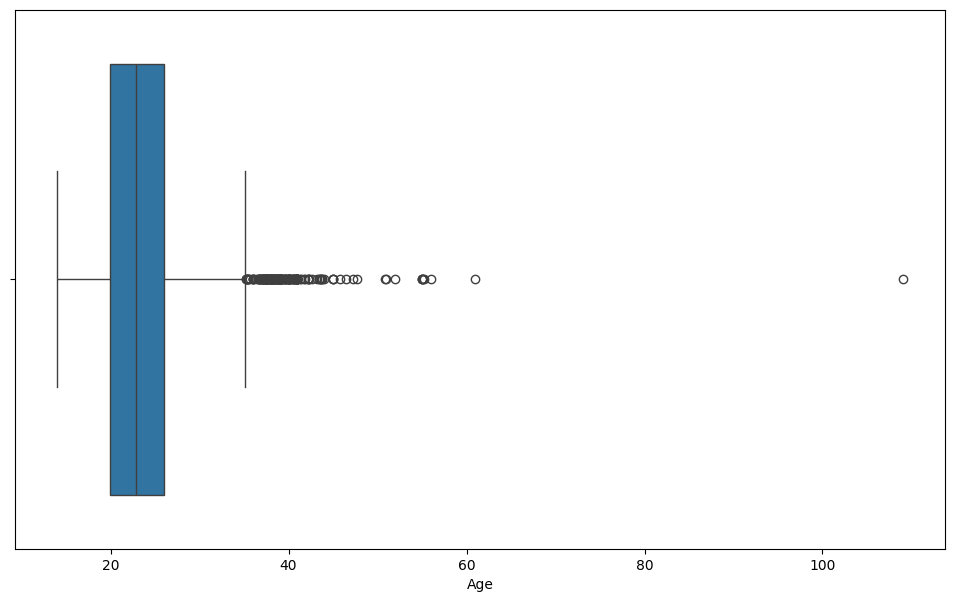

In [20]:
# Box Plot
plt.figure(figsize=(12, 7))
sns.boxplot(x='Age', data=data)

There might me an outlier but this may not be an error as someone may be 109 years old

In [21]:
# Finding the numbers of autlieres
Q1 = data['Age'].quantile(0.25)
Q3 = data['Age'].quantile(0.75)
IQR = Q3 - Q1

print("Q1:", Q1)
print("Q3:", Q3)
print("IQR:", IQR)

# Calculate lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = data[(data['Age'] < lower_bound) | (data['Age'] > upper_bound)]

# Count the number of outliers
number_of_outliers = len(outliers)

print(f"Number of outliers: {number_of_outliers}")

Q1: 19.9035615
Q3: 26.0
IQR: 6.096438500000001
Number of outliers: 168


To address outliers a logarithmic scale was applied.

In [22]:
# Apply logarithmic scaling
data['Age_log'] = np.log1p(data['Age'])

<Axes: xlabel='Age_log', ylabel='Count'>

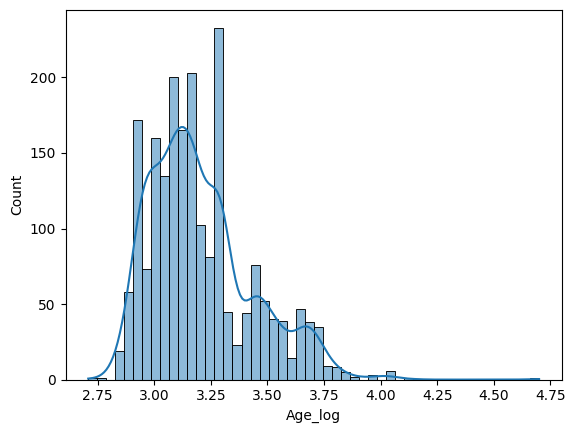

In [23]:
sns.histplot(data=data,x='Age_log', kde=True)

As the distribution is still skewed age was categorised using bins.

The categories: Infant = 0-1 year Toddler = 2-4 yrs Child = 5-12 yrs Teen = 13-19 yrs Adult = 20-39 yrs Middle Age Adult = 40-59 yrs Senior Adult = 60+ were applied as bins.

Boundaries were sourced from:
https://integrishealth.org/resources/on-your-health/2015/october/stages-of-life-health-for-every-age

In [24]:
# Define bins and labels
# Since the min age is 14
bins = [13, 19, 39, 59, float('inf')]
age_groups = {'Teen': 1, 'Adult': 2, 'Middle Age Adult': 3, 'Senior Adult': 4}

# Categorise ages2
data['Age'] = pd.cut(data['Age'], bins=bins, labels=list(age_groups.keys()), right=True, include_lowest=True)
data['Age'] = data['Age'].astype(str).map(age_groups).astype(int)


data.drop(columns='Age_log', inplace=True)

<Axes: xlabel='Age', ylabel='Count'>

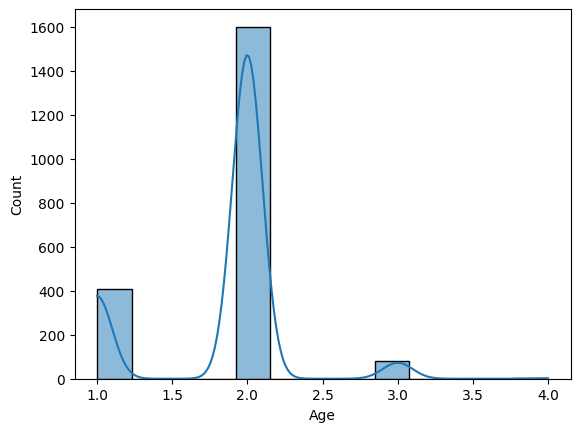

In [25]:
sns.histplot(data=data,x='Age', kde=True)

### Height and	Weight

Height weight exhibit high correlation. Calculating BMI may be a more effective feature for obesity prediction.

First a joint plot was created.

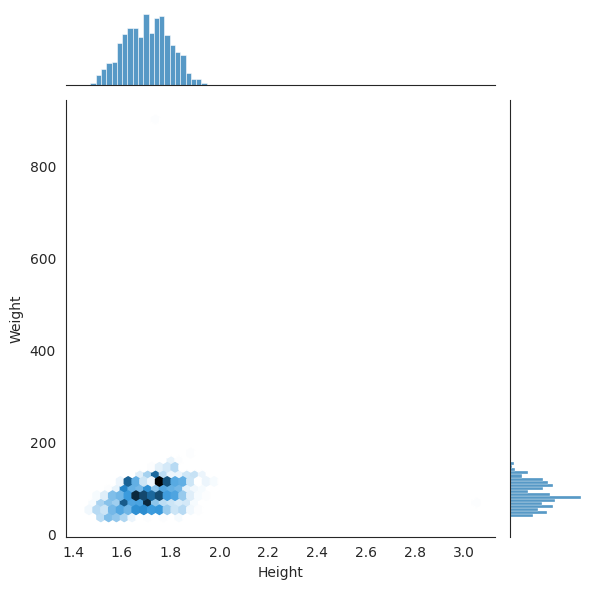

In [26]:
with sns.axes_style('white'):
    sns.jointplot(data, x="Height", y="Weight", kind='hex')

### BMI

BMI was created and added as a feature.

In [27]:
# adding BMI Caclulate BMI
data['BMI'] = data['Weight'] / (data['Height'] ** 2)

Meals and MealsBetw could be combined as there is not a standard way we will keep both as they are.

### Dropping

Since BMI was calculate height and weight was dropped.

In [28]:
data.drop(['Height', 'Weight', 'FD'], axis=1, inplace=True)

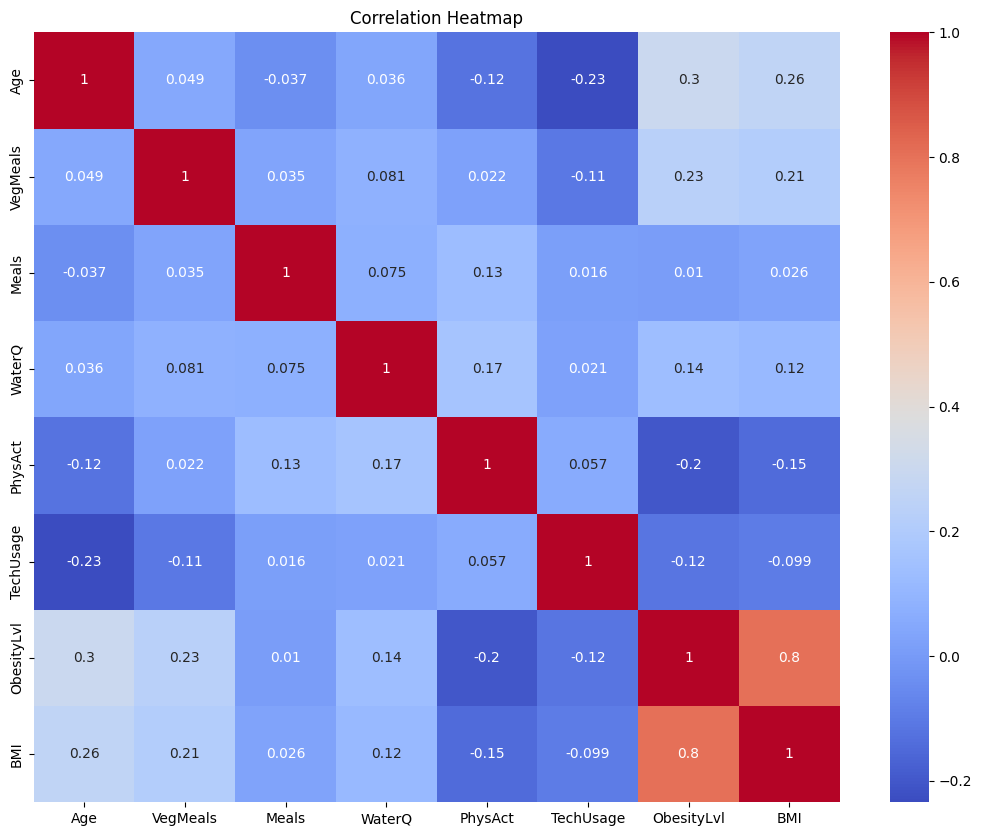

In [29]:
plot_correlationN()

BMI has the highest correlation with the target variable

In [30]:
# Function to see if there is a significan relationship between other variables and the target variable

def relationship_target_c(variable_test):
  # Creating the contingency table
  contingency_table = pd.crosstab(data[variable_test], data['ObesityLvl'])

  # Performing the chi-squared test
  chi2, p, dof, _ = chi2_contingency(contingency_table)

  # Results
  print("Chi-Squared Test Statistic:", chi2)
  print("p-value:", p)
  print("Degrees of Freedom:", dof)

  if p < 0.05:
      print(f"There is a significant relationship between {variable_test} and 'ObesityLvl' (p ({p}) < 0.05).")
  else:
      print(f"There is no significant relationship between {variable_test}' and 'ObesityLvl' (p ({p}) ≥ 0.05).")


def relationship_target_numeric(data, numeric_variable, target_variable='ObesityLvl'):

#Performing a One-Way ANOVA test to see if there is a significant for numeric variables

    categories = data[target_variable].unique()

    # Creating a list of data samples (one for each category)
    groups = []
    for category in categories:
        group_data = data[data[target_variable] == category][numeric_variable]#.dropna()
        if not group_data.empty:
            groups.append(group_data)

    # Check if we have at least 2 groups to compare
    if len(groups) < 2:
        print(f"Only one valid data group found for '{target_variable}'. Cannot perform ANOVA.")
        return

    # Perform the One-Way ANOVA test
    f_stat, p_value = f_oneway(*groups)

    # Print Results
    print(f"F-Statistic: {f_stat:.4f}")
    print(f"p-value: {p_value:.4f}")

    # Interpret the p-value
    if p_value < 0.05:
        print(f"Result: There is a significant difference in the mean of '{numeric_variable}' across '{target_variable}' groups.")
        print(f"(p ({p_value:.4f}) < 0.05).")
    else:
        print(f"Result: There is NO significant difference in the mean of '{numeric_variable}' across '{target_variable}' groups.")
        print(f"(p ({p_value:.4f}) ≥ 0.05).")



In [31]:
for var in categoriacal_features:
  relationship_target_c(var)

Chi-Squared Test Statistic: 656.8014444161677
p-value: 1.2936047240600132e-138
Degrees of Freedom: 6
There is a significant relationship between Gender and 'ObesityLvl' (p (1.2936047240600132e-138) < 0.05).
Chi-Squared Test Statistic: 613.1577362007821
p-value: 3.383583508529759e-129
Degrees of Freedom: 6
There is a significant relationship between family_overweight and 'ObesityLvl' (p (3.383583508529759e-129) < 0.05).
Chi-Squared Test Statistic: 229.63675292242044
p-value: 9.153137929159215e-47
Degrees of Freedom: 6
There is a significant relationship between HCF and 'ObesityLvl' (p (9.153137929159215e-47) < 0.05).
Chi-Squared Test Statistic: 722.3746814157818
p-value: 1.0101138730552324e-141
Degrees of Freedom: 18
There is a significant relationship between MealsBetw and 'ObesityLvl' (p (1.0101138730552324e-141) < 0.05).
Chi-Squared Test Statistic: 31.69369172439198
p-value: 1.8678285194701964e-05
Degrees of Freedom: 6
There is a significant relationship between SMOKE and 'ObesityLvl

In [32]:
numeric_features = list(numeric_features)
numeric_features.remove('Height')
numeric_features.remove('Weight')
numeric_features.remove('FD')
for var in numeric_features:
  relationship_target_numeric(data,var)

F-Statistic: 47.7698
p-value: 0.0000
Result: There is a significant difference in the mean of 'Age' across 'ObesityLvl' groups.
(p (0.0000) < 0.05).
F-Statistic: 110.4308
p-value: 0.0000
Result: There is a significant difference in the mean of 'VegMeals' across 'ObesityLvl' groups.
(p (0.0000) < 0.05).
F-Statistic: 26.8724
p-value: 0.0000
Result: There is a significant difference in the mean of 'Meals' across 'ObesityLvl' groups.
(p (0.0000) < 0.05).
F-Statistic: 15.4292
p-value: 0.0000
Result: There is a significant difference in the mean of 'WaterQ' across 'ObesityLvl' groups.
(p (0.0000) < 0.05).
F-Statistic: 18.0020
p-value: 0.0000
Result: There is a significant difference in the mean of 'PhysAct' across 'ObesityLvl' groups.
(p (0.0000) < 0.05).
F-Statistic: 8.1421
p-value: 0.0000
Result: There is a significant difference in the mean of 'TechUsage' across 'ObesityLvl' groups.
(p (0.0000) < 0.05).


The variable with the lowest F-Statistic has the weakest relationship .

Weakest: TechUsage (F-Statistic: 7.8767)MM

Strongest: Weight (F-Statistic: 536.1650)

Although some variables have low correlation, they are still statistically significant, therefore these variables will not be dropped.

## Encoding Categoriacal features

One hot encoding for categorical features
and for ordinal varibale number ecoding was applied.

In [33]:
categoriacal_features

Index(['Gender', 'family_overweight', 'HCF', 'MealsBetw', 'SMOKE',
       'CaloriesMonitor', 'AlcConsume', 'TransMeans', 'ObesityLvl'],
      dtype='object')

In [34]:
# Checking the values for the feature to define if ordinal or categorical
data['AlcConsume'].unique()

array(['no', 'Sometimes', 'Frequently', 'Always'], dtype=object)

In [35]:
# separating the odinal features
categoriacal_features = ['Gender', 'family_overweight', 'HCF', 'SMOKE', 'CaloriesMonitor', 'TransMeans']
categoriacal_ordinal_features = ['MealsBetw', 'AlcConsume']

In [36]:
# One-hot encode the categorical columns
data = pd.get_dummies(data, columns=categoriacal_features, drop_first=True)

In [37]:
# Devining mapping for ordinal
ordinal_mapping = {
    'no': 0,
    'Sometimes': 1,
    'Frequently': 2,
    'Always': 3
}

# Apply the mapping to data
data['MealsBetw'] = data['MealsBetw'].map(ordinal_mapping)
data['AlcConsume'] = data['AlcConsume'].map(ordinal_mapping)

In [38]:
data.head()

,Age,VegMeals,Meals,MealsBetw,WaterQ,PhysAct,TechUsage,AlcConsume,ObesityLvl,BMI,Gender_Male,family_overweight_yes,HCF_yes,SMOKE_yes,CaloriesMonitor_yes,TransMeans_Bike,TransMeans_Motorbike,TransMeans_Public_Transportation,TransMeans_Walking
0,2,2.0,3.0,1,2.0,0.0,1.0,0,2,24.386526,False,True,False,False,False,False,False,True,False
1,2,3.0,3.0,1,3.0,3.0,0.0,1,2,24.238227,False,True,False,True,True,False,False,True,False
2,2,2.0,3.0,1,2.0,2.0,1.0,2,2,23.765432,True,True,False,False,False,False,False,True,False
3,2,3.0,3.0,1,2.0,2.0,0.0,2,3,26.851852,True,False,False,False,False,False,False,False,True
4,2,2.0,1.0,1,2.0,0.0,0.0,1,4,28.342381,True,False,False,False,False,False,False,True,False


In [39]:
# Rounding numbers
#data['FD'] = (data['FD']*100).astype(np.uint16)
data['BMI'] = (data['BMI']*100).astype(np.uint16)

In [40]:
# Converting Boolean columns to Binary int
boolian_columns = data.select_dtypes(include=['bool']).columns
#print(f"Boolean columns: {bool_columns}")
data[boolian_columns] = data[boolian_columns].astype(int)

In [41]:
data.head()

,Age,VegMeals,Meals,MealsBetw,WaterQ,PhysAct,TechUsage,AlcConsume,ObesityLvl,BMI,Gender_Male,family_overweight_yes,HCF_yes,SMOKE_yes,CaloriesMonitor_yes,TransMeans_Bike,TransMeans_Motorbike,TransMeans_Public_Transportation,TransMeans_Walking
0,2,2.0,3.0,1,2.0,0.0,1.0,0,2,2438,0,1,0,0,0,0,0,1,0
1,2,3.0,3.0,1,3.0,3.0,0.0,1,2,2423,0,1,0,1,1,0,0,1,0
2,2,2.0,3.0,1,2.0,2.0,1.0,2,2,2376,1,1,0,0,0,0,0,1,0
3,2,3.0,3.0,1,2.0,2.0,0.0,2,3,2685,1,0,0,0,0,0,0,0,1
4,2,2.0,1.0,1,2.0,0.0,0.0,1,4,2834,1,0,0,0,0,0,0,1,0


## Data split

In [42]:
# Separating feature to target
y = data['ObesityLvl']
X = data.drop('ObesityLvl', axis=1)

# Data scaling, to normalise value, no have varible with high number influence more
scaler = StandardScaler()
X = scaler.fit_transform(X)

On Scalling, Logistical Regression and Support Vector machine models are sensitive to feature magnitude, it is important to scan the data, however, other models such us RF do not require scaling.

Split the data into 80% for training and validation, using K Fold Cross Validation. And 20 % only for testing.

In [43]:
# Using Sk Learn Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

print(f"Train: {len(X_train)} ({len(X_train)/len(X):.1%})")
print(f"Test: {len(X_test)} ({len(X_test)/len(X):.1%})")

Train: 1672 (80.0%)
Test: 419 (20.0%)


---

# 2. **Model Training**

Here, you need to:

1.	select and compare at least three machine learning models (seen/discussed during the lectures) appropriate for your modelling;
2.	if there are hyperparameters in a selected algorithm, define a hyperparameter search protocol (you can define your own), and tune them.


We will GridSearchCV for model traing as it will allow us to test different combination of hypere paramiters, and will internally handle validation.

GridSearchCV It performs an exhaustive search over a given parameter grid to find the best combination of hyperparameters for your model, using cross-validation (CV).
The validation used is K Fold cross validation with.
5 folds - each fold ≈ 334 records for validation (Not large dataset)

The parameters where base on common paramteres investigate on other studies. [Refer to the report]

The acurracy metric chose to validate each model is F1-Score (Macro as the data is not imbalanced).

Evaluate models based on:
* Accuracy - Less reliable, but dataset is balanced
* F1-Score (Average) a Balance of Precision and Recall


In [44]:
# Write your proposed solution code here. Create more code cells if you find it necessary

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import joblib

In [45]:
def save_model(model, name):
    # save the model
    filename = name + '.joblib'
    joblib.dump(model, filename)

 Showing the results of each parameter combination function

In [46]:
def show_grid_training(RF_grid_search):
  """
  Function to show the result throut traing of grid search CV
  """
  results_df = pd.DataFrame(RF_grid_search.cv_results_)
  results_expanded = results_df['params'].apply(pd.Series)
  results_expanded['mean_test_score'] = results_df['mean_test_score']
  results_expanded = results_expanded.sort_values(by='mean_test_score', ascending=False)

  # Display top results
  return results_expanded


parameter sensitivity plot function we will base on “partial dependence for hyperparameters”, where we will fix all other parameters at their best values and vary one at a time, observing how the validation performance changes.

In [47]:

def plot_param_effect(grid_search, metric='mean_test_score', top_n=None):
    """
    Plot the effect of each hyperparameter on model performance.
    """
    # Extracting results into DataFrame
    results_df = pd.DataFrame(grid_search.cv_results_)
    params_df = results_df['params'].apply(pd.Series)
    params_df[metric] = results_df[metric]

    if top_n:
        params_df = params_df.sort_values(by=metric, ascending=False).head(top_n)

    # Getting the bes
    best_params = grid_search.best_params_

    n_params = len(best_params)
    plt.figure(figsize=(5 * n_params, 4))

    for i, param in enumerate(best_params.keys()):
        plt.subplot(1, n_params, i + 1)

        # average performance for each parameter value
        grouped = params_df.groupby(param)[metric].mean().reset_index()

        # Sorting values by parameter (helps numeric parameters)
        grouped = grouped.sort_values(by=param)

        sns.lineplot(data=grouped, x=param, y=metric, marker='o')

        # best value
        best_value = best_params[param]
        best_score = grouped[grouped[param] == best_value][metric].values
        if len(best_score) > 0:
            plt.scatter(best_value, best_score[0], color='red', s=100, zorder=5, label='Best')

        plt.title(f"Effect of '{param}' on {metric}")
        plt.xlabel(param)
        plt.ylabel(metric)
        plt.legend()
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


Parameter sensitivity with time and overfiting

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_param_effect_detailed(grid_search, metric='f1_macro', top_n=None):
    """
    Visualise the effect of each hyperparameter on:
    Mean train and test scores over the all folds (to check overfitting)
    Train time (computational cost)
    """
    # Extract results
    results_df = pd.DataFrame(grid_search.cv_results_)
    params_df = results_df['params'].apply(pd.Series)

    # Attach relevant performance metrics, the mean over 5 folds
    params_df['mean_test_score'] = results_df['mean_test_score']
    params_df['mean_train_score'] = results_df.get('mean_train_score', None)
    params_df['mean_fit_time'] = results_df['mean_fit_time']

    if top_n:
        params_df = params_df.sort_values(by='mean_test_score', ascending=False).head(top_n)

    best_params = grid_search.best_params_
    n_params = len(best_params)

    # Setup figure
    plt.figure(figsize=(6 * n_params, 10))

    for i, param in enumerate(best_params.keys()):
        grouped = params_df.groupby(param).mean(numeric_only=True).reset_index()
        grouped = grouped.sort_values(by=param)

        # --- Subplot 1: Train vs Test score ---
        plt.subplot(2, n_params, i + 1)
        sns.lineplot(data=grouped, x=param, y='mean_test_score', marker='o', label='Test', color='blue')
        if 'mean_train_score' in grouped.columns and grouped['mean_train_score'].notna().any():
            sns.lineplot(data=grouped, x=param, y='mean_train_score', marker='s', label='Train', color='orange')

        best_val = best_params[param]
        if best_val in grouped[param].values:
            best_test = grouped.loc[grouped[param] == best_val, 'mean_test_score'].values[0]
            plt.scatter(best_val, best_test, s=120, color='red', label='Best', zorder=5)

        plt.title(f"Performance vs '{param}'")
        plt.xlabel(param)
        plt.ylabel(metric)
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Train time
        plt.subplot(2, n_params, i + 1 + n_params)
        sns.lineplot(data=grouped, x=param, y='mean_fit_time', marker='o', color='green')

        plt.title(f"Fit time vs '{param}'")
        plt.xlabel(param)
        plt.ylabel('Mean fit time (s)')
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

## Logistic Regression

In [ ]:
LR = LogisticRegression(max_iter=10000)

LR_paramiters = {
    "solver": ['saga', 'liblinear'], # 'l1' penalty only works with 'liblinear' and 'saga'
    "penalty": ['l1', 'l2'],
    "C": [0.01, 0.1, 1, 10, 100],
    "tol": [1e-4, 1e-3, 1e-2]
}

grid_search_lr = GridSearchCV(LR, LR_paramiters,
                              cv=5, scoring='f1_macro', n_jobs=-1,
                              verbose=3, return_train_score=True# To check overfitting)
                              )
grid_search_lr.fit(X_train, y_train)


print(f"Logistic Regression - Best parameter: {grid_search_lr.best_params_}")
print(f"Logistic Regression - Best F1-score: {grid_search_lr.best_score_:.2f}")

LR_best = grid_search_lr.best_estimator_
save_model(LR_best,"LogisticRegresion")

Fitting 5 folds for each of 60 candidates, totalling 300 fits


In [ ]:
show_grid_training(grid_search_lr)

In [ ]:
plot_param_effect(grid_search_lr)

In [ ]:
plot_param_effect_detailed(grid_search_lr)

## Random Forest

In [ ]:
RF = RandomForestClassifier()

# Updated parameter grid
RF_paramiters = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [50, 100, 200]
}

RF_grid_search = GridSearchCV(RF, RF_paramiters, cv=5, scoring='f1_macro', n_jobs=-1, return_train_score=True)
RF_grid_search.fit(X_train, y_train)


print(f"Random Forest - Best parameter: {RF_grid_search.best_params_}")
print(f"Random Forest - Best F1-score: {RF_grid_search.best_score_:.2f}")

RF_best = RF_grid_search.best_estimator_
save_model(RF_best,"RandomForest")

In [ ]:
show_grid_training(RF_grid_search)

In [ ]:
plot_param_effect_detailed(RF_grid_search)

Althoguh the train and test seem apart it is just the scale of the performances where mostly above 0.95

## Support vector machine

In [ ]:
SVM = SVC()

SVM_paramiters = {'C':[0.5, 0.75, 1],
              'kernel':['rbf','linear'],
              'gamma': ['scale', 'auto']#, 0.1, 1]
              }

SVM_grid_search = GridSearchCV(SVM, SVM_paramiters, cv=5, scoring='f1_macro', n_jobs=-1, return_train_score=True)
SVM_grid_search.fit(X_train, y_train)


print(f"Support Vector Machine - Best parameter: {SVM_grid_search.best_params_}")
print(f"Support Vector Machine - Best F1-score: {SVM_grid_search.best_score_:.2f}")

SVM_best = SVM_grid_search.best_estimator_
save_model(SVM_best,"SupportVectorMachine")

In [ ]:
plot_param_effect_detailed(SVM_grid_search)

## Nayve Bayes

In [ ]:
NB = GaussianNB()

NB_paramiters = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
}

NB_grid_search = GridSearchCV(NB, NB_paramiters, cv=5, scoring='f1_macro', n_jobs=-1, return_train_score=True)
NB_grid_search.fit(X_train, y_train)


print(f"Naive Bayes - Best parameter: {NB_grid_search.best_params_}")
print(f"Naive Bayes - Best F1-score: {NB_grid_search.best_score_:.2f}")

NB_best = NB_grid_search.best_estimator_
save_model(NB_best,"NayveBias")

In [ ]:
plot_param_effect_detailed(NB_grid_search)

---

# 3. **Evaluate models**

Here, you need to:

1.	test the model (the best one you obtained from the above stage) on the appropriate set


All model but NB performed well, but the best was RF:

Random Forest - Best parameter: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}

Random Forest - Best F1-score: 0.98

Now we test the models on the unseen testing set. The primary evaluation metric will be accuracy, chosen because the dataset is not imbalanced. We will also compute the F1-score, which is the harmonic mean between precision and recall. Additionally, the AUC (Area Under the Curve) will be evaluated to analyse the model’s performance. Although AUC is most straightforward to calculate for binary classification, in this case, class probability predictions can be obtained using the predict_proba function in scikit-learn. The Random Forest model allows AUC scores to be computed, although for some models, this metric is not directly applicable to multi-class classification without adaptation.

In [ ]:
# Mapping the label back to text for interpretation
labels_mapping_inv = {
    1: 'Insufficient_Weight',
    2: 'Normal_Weight',
    3: 'Overweight_Level_I',
    4: 'Overweight_Level_II',
    5: 'Obesity_Type_I',
    6: 'Obesity_Type_II',
    7: 'Obesity_Type_III'
}
class_labels = [
    'Insufficient_Weight',
    'Normal_Weight',
    'Overweight_Level_I',
    'Overweight_Level_II',
    'Obesity_Type_I',
    'Obesity_Type_II',
    'Obesity_Type_III'
]

In [ ]:
def evaluate_model(model, X_test, y_test):

    # Predictions
    y_pred = model.predict(X_test)

    # Performance metrics for multi-class
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall= recall_score(y_test,y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')#, average='weighted')
    # ROC curve — only valid for binary classification
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr', average='macro')

    print("\n")
    #print('Precision: {0:0.5f}'.format(precision))
    #print('Recall: {0:0.5f}'.format(recall))
    print('Accurecy: {0:0.5f}'.format(accuracy))
    print('F1: {0:0.5f}'.format(f1))
    print('AUC Score: {0:0.5f}'.format(roc_auc))
    print("\n")
    print(f"Classification Report: ")
    print(classification_report(y_test, y_pred, target_names=class_labels))


In [ ]:
def plot_confusionm(model, X_test, y_test):

    # Predictions
    y_pred = model.predict(X_test)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    cm_display.plot(cmap=plt.cm.Blues)
    plt.xticks(rotation=45)
    plt.title(f'Confusion Matrix')
    plt.show()


In [ ]:
evaluate_model(RF_best, X_test, y_test)

In [ ]:
plot_confusionm(RF_best, X_test, y_test)

The Random Forest classifier achieved excellent performance on the unseen test data, with an accuracy of 0.96181, an F1-score of 0.96063, and an AUC score of 0.999, indicating strong predictive capability and clear class separation. The classification report and confusion matrix confirm that the model performs consistently well across all categories, with most predictions correctly aligned along the diagonal and only minor misclassifications between adjacent weight groups such as Normal Weight and Overweight Level I. The obesity-related classes are classified almost perfectly, showing the model’s strong ability to distinguish higher obesity levels. Overall, the model demonstrates high reliability, strong generalisation, and effective discrimination across all weight levels, making it highly suitable for multi-class the medical organization specializing in obesity treatment.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Extract feature importances and names
importances = RF_best.feature_importances_
feature_names = X_test.columns

# 2. Create a DataFrame for easy sorting and plotting
fi_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# 3. Sort the DataFrame by importance in descending order
fi_df.sort_values(by='Importance', ascending=False, inplace=True)

In [ ]:
# 4. Plot the results
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=fi_df)
plt.title('Random Forest Feature Importance (MDI)')
plt.show()